In [2]:
import functools
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.optim import Adam
from torch.utils.data import DataLoader

#from tutorial import ScoreNet

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Inherit-model-class" data-toc-modified-id="Inherit-model-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inherit model class</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Variance-Preserving-SDE" data-toc-modified-id="Variance-Preserving-SDE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Variance Preserving SDE</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Sample" data-toc-modified-id="Sample-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sample</a></span><ul class="toc-item"><li><span><a href="#Samplers" data-toc-modified-id="Samplers-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Samplers</a></span></li><li><span><a href="#Sampling" data-toc-modified-id="Sampling-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Sampling</a></span></li></ul></li></ul></div>

## Inherit model class

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
  
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

## Setup

In [4]:
device = 'cuda'
sigma = 25.
n_epochs = 10
batch_size = 32
lr = 1e-4

def marginal_prob_std(t,sigma):
    t = torch.tensor(t, device=device)
    var = torch.sqrt((sigma**(2 * t) - 1.) / (2. * np.log(sigma)))
    return var 

def diffusion_coeff(t, sigma): 
    return torch.tensor(sigma**t, device=device)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(t=random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

# Pass parameter by default and change prototype
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

## Variance Preserving SDE

Variance Preserving diffusion SDE:

\begin{align*}
d \mathbf{x} = - \frac{1}{2} \beta(t) \mathbf{x} dt + \sqrt{\beta(t)}d\mathbf{w}
\end{align*}

This follows the general SDE form $d \mathbf{x} = f(\mathbf{x}, t) dt + g(t) d \mathbf{w}$ which has the general conditional linear Gaussian distribution: $p(x_0|x_t) = \mathcal{N}(x_t; \alpha(t)x_0, \beta^2(t)I)$ where $\alpha: [0,1] \rightarrow \mathbb{R}$,  $\beta: [0,1] \rightarrow \mathbb{R}$.

In $\textit{Applied Stochastic Differential Equations}$ by Särkkä and Solin (2019), we learn that $\alpha, \beta$ can be derived analytically from $f(\mathbf{x}, t), g(t)$. In our case, we have:

\begin{align*}
\begin{cases}
  f(\mathbf{x}, t) = - \frac{1}{2} \beta(t) \mathbf{x} \\
  g(t) = \sqrt{\beta(t)}
\end{cases}
\end{align*}
\begin{align*}
\begin{cases}
  \alpha(t) = \exp{c(t)} \\ 
  \beta^2(t) = \sqrt{1 - \exp(2c(t))} \quad \text{with} \ c(t) = -\frac{t^2}{4}(\beta_1 - \beta_0) - \frac{t}{2}\beta_0
\end{cases}
\end{align*}

Therefore:
\begin{align*}
  p(x_0|x_t) = \mathcal{N}(x_t; \exp{c(t)}x_0, \sqrt{1 - \exp(2c(t))}I)
\end{align*}

In [39]:
def vp_marginal_prob_std(t, beta_min, beta_max):
    coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    #mean = torch.exp(coeff) * x
    var = torch.sqrt(1 - torch.exp(2. * coeff))
    return var

def vp_drift_coeff(x, t, beta_min, beta_max):
    # def of beta_t from Yang Song's repo score_sde
    beta_t = beta_min + t * (beta_max - beta_min)
    if (beta_t.dim() == 1) and (x.dim() > 1):
        beta_t = beta_t[:, None, None, None]
    drift = -.5 * beta_t * x
    return drift

def vp_diffusion_coeff(t, beta_min, beta_max):
    # def of beta_t from Yang Song's repo score_sde
    beta_t = beta_min + t * (beta_max - beta_min)
    diffusion = torch.sqrt(beta_t)
    return diffusion

In [40]:
beta_min = .01
beta_max = 5
vp_marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
vp_drift_coeff_fn = functools.partial(vp_drift_coeff, beta_min=beta_min, beta_max=beta_max)
vp_diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, beta_min=beta_min, beta_max=beta_max)

## Training

In [ ]:
# setup
n_epochs = 50
batch_size = 32
lr = 1e-4

# dataset
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True);
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4);

# model + optimizer
score_model_vp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=vp_marginal_prob_std_fn))
score_model_vp = score_model_vp.to(device)
optimizer = Adam(score_model_vp.parameters(), lr=lr)

# training
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)    
        loss = loss_fn(score_model_vp, x, vp_marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0] 
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model_vp.state_dict(), 'ckpt_vp.pth')

## Sample

### Samplers

In [38]:
from scipy import integrate

def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           drift_coeff=None,
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if drift_coeff == None:
                mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            else:
                f = drift_coeff(x, batch_time_step)
                mean_x = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x

def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               drift_coeff=None,
               batch_size=64, 
               num_steps=500, 
               snr=0.16,                
               device='cuda',
               eps=1e-3):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            # TODO revisit this for VP
            g = diffusion_coeff(batch_time_step)
            if drift_coeff == None:
                x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            else:
                f = drift_coeff(x, batch_time_step)
                x_mean = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                drift_coeff=None,
                batch_size=64, 
                atol=1e-5, 
                rtol=1e-5, 
                device='cuda', 
                z=None,
                eps=1e-3):
    t = torch.ones(batch_size, device=device)
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
          * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
    shape = init_x.shape
    
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        with torch.no_grad():    
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)

    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t    
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        f = drift_coeff(x, torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps) + f

    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)
    return x


### Sampling

In [46]:
from torchvision.utils import make_grid
def sample(sampler):
    samples = sampler(score_model, 
                    vp_marginal_prob_std_fn,
                    vp_diffusion_coeff_fn,
                    vp_drift_coeff_fn,
                    sample_batch_size, 
                    device=device)
    return samples

def plot_samples(samples):
    samples = samples.clamp(0.0, 1.0)
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()


# fresh model
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=vp_marginal_prob_std_fn))
score_model = score_model.to(device)

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
model_pth = 'ckpt_vp.pth' #@param ['ckpt_subvp.pth', 'ckpt_vp.pth'] {'type': 'string'}
ckpt = torch.load(model_pth, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

Number of function evaluations: 272


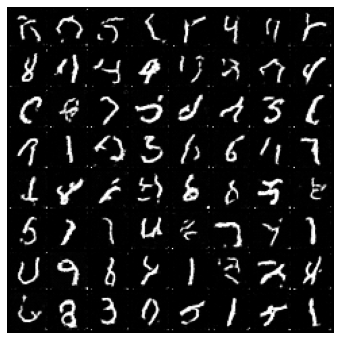

In [43]:
## Generate samples using ODE.
sampler = ode_sampler
samples = sample(sampler)
plot_samples(samples)

  0%|          | 0/500 [00:00<?, ?it/s]

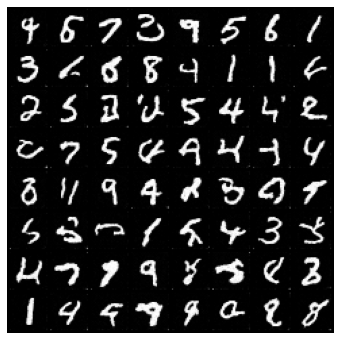

In [41]:
## Generate samples using Euler-Maruyama.
sampler = Euler_Maruyama_sampler
samples = sample(sampler)
plot_samples(samples)

  0%|          | 0/500 [00:00<?, ?it/s]

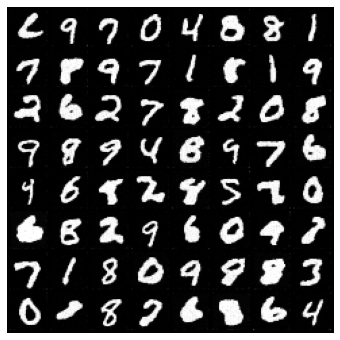

In [47]:
## Generate samples using Predictor-Corrector.
sampler = pc_sampler
samples = sample(sampler)
plot_samples(samples)